# Multiple Scatter Simulations with `k100Sim`

The previous `iPy` notebook `ms_simulation_yield.ipynb` saved some data. Now, I want to work with a reduced version of this to produce some useful plots. 

In [1]:
import numpy as np
import pandas as pd
import sima2py as sapy

In [2]:
#play around with some hits data stored in h5 file
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
f = h5py.File("/data/chocula/villaa/k100Sim_Data/252Cf/k100_252Cf_noshield_NRs.h5","r")

for i in f:
    print(i)

nr_energies = np.asarray(f['nr_Fano/nr_energies'])
nr_hits = np.asarray(f['nr_Fano/nr_hits'])

print(np.shape(nr_energies))

nr_Fano
(319253, 11)


In [3]:
#make some histograms

xmax = 100
n_ss,nx_ss = np.histogram(np.sum(nr_energies[nr_hits==1,:],1)*1000,250,range=(0,xmax))
n_ms,nx_ms = np.histogram(np.sum(nr_energies[nr_hits>1,:],1)*1000,250,range=(0,xmax))


xc = (nx_ss[:-1] + nx_ss[1:]) / 2

In [4]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

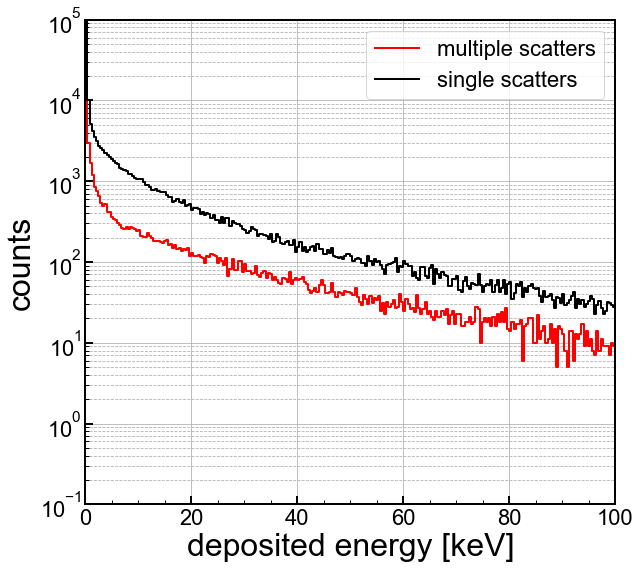

In [5]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1e4
ax1.step(xc,n_ms, where='mid',color='r', linestyle='-', \
         label='multiple scatters', linewidth=2)
ax1.step(xc,n_ss, where='mid',color='k', linestyle='-', \
         label='single scatters', linewidth=2)




#tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
#ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, xmax) #in pairs
ax1.set_ylim(0.1,1e5)
ax1.set_xlabel('deposited energy [keV]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/Cf252_ms.png')
plt.show()

In [6]:
#adding the yield [Lindhard]
import lindhard as lind #custom library in lindhard.py



#try to set up lindhard calc for many k's
par = lind.getLindhardPars('Ge')
y = lind.getLindhard(par,True) #get standard Lindhard yiedl
yv = np.vectorize(y) #get standard Lindhard yiedl)



#voltage and average energy per pair
V=4
egam = 3.3 #eV per pair

In [7]:
import resfuncRead as rfr

#read the files
ptres = rfr.getRFunc('data/jardin_ptres.txt')
qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

#print(ptres)
#print(qres)

In [8]:
#make the resolution functions
fpt = rfr.makeRFunc(ptres[1]['sqrt'])
fq = rfr.makeRFunc(qres[1]['sqrt'],True)
fptv = np.vectorize(fpt)
fqv = np.vectorize(fq)

In [9]:
NRedep_all = nr_energies*1000
NRedep_ee_all = NRedep_all*yv(NRedep_all*1000) #gotta use eV here

In [10]:
Enr = NRedep_all

Ptnr = Enr + (V/egam)*yv(Enr*1000.0)*Enr
Ptnr = Ptnr + np.random.normal(0.0,fptv(Ptnr))
Qnr = yv(Enr*1000.0)*Enr
Qnr = Qnr + np.random.normal(0.0,fqv(Qnr))

Qnr_sum = np.sum(Qnr,1)
Ptnr_sum = np.sum(Ptnr,1)

Ernr = Ptnr_sum - (V/egam)*Qnr_sum
Ynr = Qnr_sum/Ernr

In [11]:
#get the example bands
bpar_er = rfr.getBandFunc('data/erband_R133')
bpar_nr = rfr.getBandFunc('data/nrband_R133')

yer_mu = rfr.makeBFunc(bpar_er[1]['mu'])
yer_muv = np.vectorize(yer_mu)
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True)
yer_sigv = np.vectorize(yer_sig)

ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

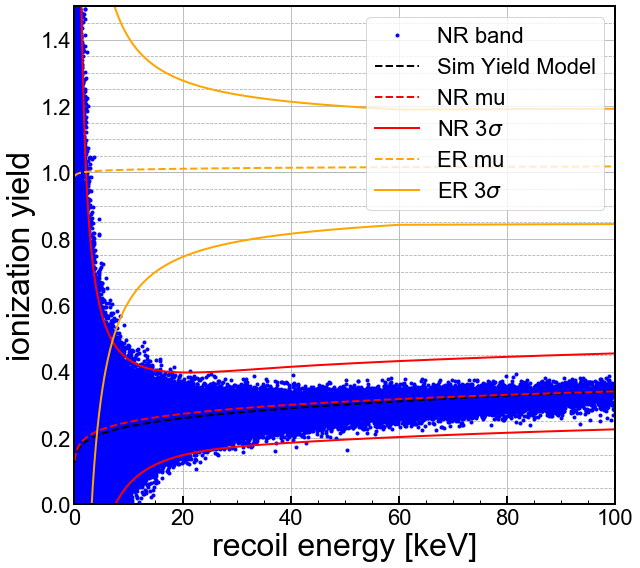

In [12]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)
#ax1.plot(Erer,Yer,'o',color='k', label='ER band',linewidth=2,markersize=3)
ax1.plot(Ernr,Ynr,'o',color='b', label='NR band',linewidth=2,markersize=3)
ax1.plot(X,yv(X*1000),'k--',label='Sim Yield Model')

ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.5



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/Cf252_ms_nryieldband.png')
plt.show()

In [13]:
#let's do this again for just single scatters. 
NRedep_all_ss = nr_energies[nr_hits==1]*1000
NRedep_ee_all_ss = NRedep_all_ss*yv(NRedep_all_ss*1000) #gotta use eV here

Enr_ss = NRedep_all_ss

Ptnr_ss = Enr_ss + (V/egam)*yv(Enr_ss*1000.0)*Enr_ss
Ptnr_ss = Ptnr_ss + np.random.normal(0.0,fptv(Ptnr_ss))
Qnr_ss = yv(Enr_ss*1000.0)*Enr_ss
Qnr_ss = Qnr_ss + np.random.normal(0.0,fqv(Qnr_ss))

Qnr_sum_ss = np.sum(Qnr_ss,1)
Ptnr_sum_ss = np.sum(Ptnr_ss,1)

Ernr_ss = Ptnr_sum_ss - (V/egam)*Qnr_sum_ss
Ynr_ss = Qnr_sum_ss/Ernr_ss

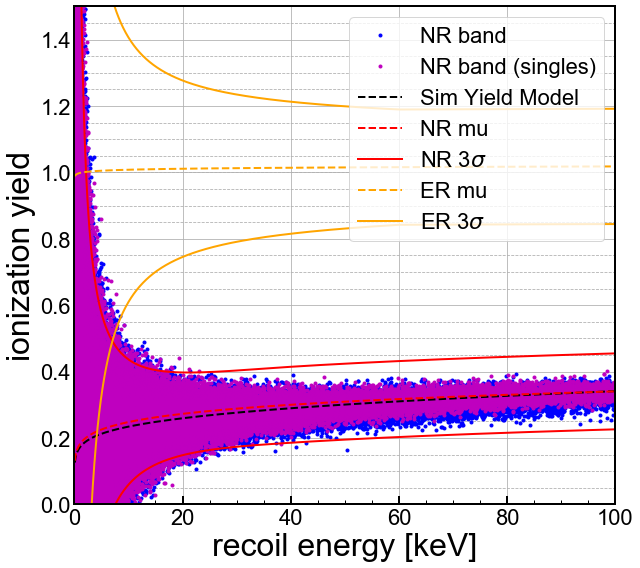

In [14]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)
#ax1.plot(Erer,Yer,'o',color='k', label='ER band',linewidth=2,markersize=3)
ax1.plot(Ernr,Ynr,'o',color='b', label='NR band',linewidth=2,markersize=3)
ax1.plot(Ernr_ss,Ynr_ss,'o',color='m', label='NR band (singles)',linewidth=2,markersize=3)
ax1.plot(X,yv(X*1000),'k--',label='Sim Yield Model')


ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.5



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/Cf252_ms_ss_nryieldband.png')
plt.show()

In [15]:
#make some histograms

yieldmax = 0.5
n_y,nx_y = np.histogram(Ynr[(Ernr>75)&(Ernr<85)],100,range=(0,yieldmax))
n_y_ss,nx_y_ss = np.histogram(Ynr_ss[(Ernr_ss>79)&(Ernr_ss<81)],100,range=(0,yieldmax))

#normalize
n_y=n_y/np.sum(n_y)
n_y_ss=n_y_ss/np.sum(n_y_ss)

xc_y = (nx_y_ss[:-1] + nx_y_ss[1:]) / 2

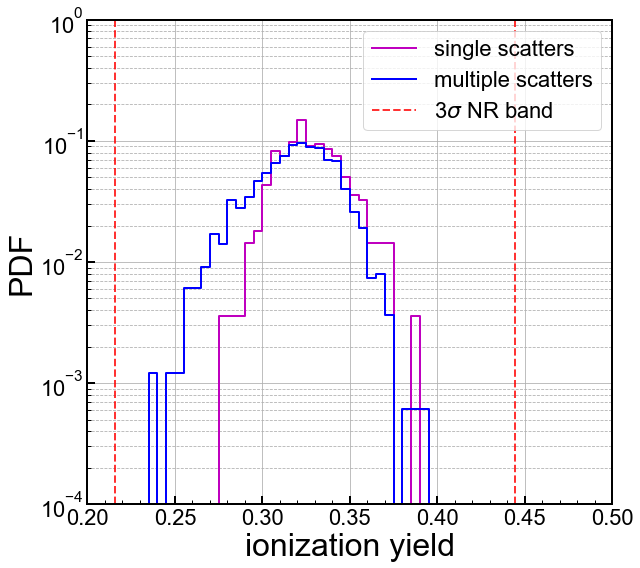

In [16]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1e3
ax1.step(xc_y,n_y_ss, where='mid',color='m', linestyle='-', \
         label='single scatters', linewidth=2)
ax1.step(xc_y,n_y, where='mid',color='b', linestyle='-', \
         label='multiple scatters', linewidth=2)



nsig=3
tlabel = '{}$\\sigma$ NR band'.format(nsig)
ax1.axvline(ynr_muv(80.0)-nsig*ynr_sigv(80.0), color='r', linestyle='--', lw=2, alpha=0.8,label=tlabel)
ax1.axvline(ynr_muv(80.0)+nsig*ynr_sigv(80.0), color='r', linestyle='--', lw=2, alpha=0.8,label=None)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0.2, yieldmax) #in pairs
ax1.set_ylim(1e-4,1)
ax1.set_xlabel('ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/1DYield_ms_ss_80keV.png')
plt.show()

In [17]:
#make some histograms

yieldmax = 0.5
n_y_low,nx_y_low = np.histogram(Ynr[(Ernr>15)&(Ernr<25)],100,range=(0,yieldmax))
n_y_ss_low,nx_y_ss_low = np.histogram(Ynr_ss[(Ernr_ss>15)&(Ernr_ss<25)],100,range=(0,yieldmax))

#normalize
n_y_low=n_y_low/np.sum(n_y_low)
n_y_ss_low=n_y_ss_low/np.sum(n_y_ss_low)

xc_y_low = (nx_y_ss_low[:-1] + nx_y_ss_low[1:]) / 2

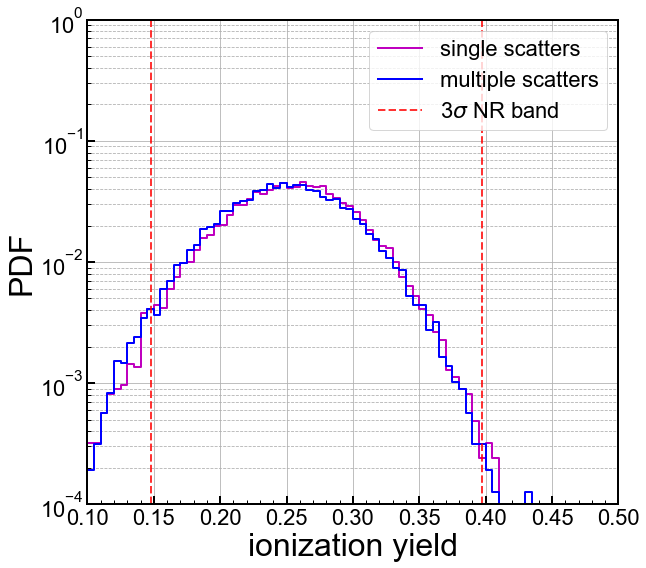

In [18]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1e3
ax1.step(xc_y_low,n_y_ss_low, where='mid',color='m', linestyle='-', \
         label='single scatters', linewidth=2)
ax1.step(xc_y_low,n_y_low, where='mid',color='b', linestyle='-', \
         label='multiple scatters', linewidth=2)



nsig=3
tlabel = '{}$\\sigma$ NR band'.format(nsig)
ax1.axvline(ynr_muv(20.0)-nsig*ynr_sigv(20.0), color='r', linestyle='--', lw=2, alpha=0.8,label=tlabel)
ax1.axvline(ynr_muv(20.0)+nsig*ynr_sigv(20.0), color='r', linestyle='--', lw=2, alpha=0.8,label=None)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0.1, yieldmax) #in pairs
ax1.set_ylim(1e-4,1)
ax1.set_xlabel('ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/1DYield_ms_ss_20keV.png')
plt.show()